#### Import libraries

In [36]:
import mord as md
import pandas as pd
import numpy as np
from sklearn import metrics
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

#### Define ordered logistic functions

In [2]:
def OL_summary_output(model):
    
    #Computes coefficients
    params = model.coef_
    
    #Computes predictions
    prediction = model.predict(x)

    #Computes metrics
    MAE = metrics.mean_absolute_error(y, prediction)
    MSE = metrics.mean_squared_error(y, prediction)
    RMSE = np.sqrt(metrics.mean_squared_error(y, prediction))

    #Creates summary dataframe
    coeff_df = pd.DataFrame(params, x.columns, columns=['Coefficient'])

    #Computes variance
    var_b = MSE*(np.linalg.inv(np.dot(x.T,x)).diagonal())

    #Computes standard error
    sd_b = np.sqrt(var_b)

    #Computes t-statistic
    ts_b = params/sd_b

    #Computes p-values
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(x)-1))) for i in ts_b]

    #Computes confidence intervals
    conf_int_inf = params - 1.96*sd_b
    conf_int_sup = params + 1.96*sd_b

    #Formats numbers for table
    sd_b = sd_b
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    #Summarizes dataframe
    coeff_df["Standard Errors"],coeff_df["t values"],coeff_df["Probabilites"], coeff_df['2.5%'], coeff_df['97.5%'] = [sd_b,ts_b,p_values, conf_int_inf, conf_int_sup]
    
    print('Mean Absolute Error:', np.round(MAE, 3))  
    print('Mean Squared Error:', np.round(MSE, 3))  
    print('Root Mean Squared Error:', np.round(RMSE,3))
    return coeff_df

def odds_ratio_summary_output(model_summary_output):
    
    model_summary_output = OL_summary_output(model_ordinal)
    coeff_OR = model_summary_output.copy()
    
    coeff_OR["Coefficient"] = np.exp(model_summary_output["Coefficient"])
    coeff_OR["Standard Errors"] = np.exp(model_summary_output["Standard Errors"])
    coeff_OR['2.5%'] = np.exp(coeff_OR['2.5%'])
    coeff_OR['97.5%'] = np.exp(coeff_OR['97.5%'])
    
    return coeff_OR

#### Read data

In [3]:
data = pd.read_csv('chis_data.csv')
data.head()

,soda_per_week,fast_food,monthly_earnings,homeowner,acc_produce,health_status,acc_produce_ALWAYS,acc_produce_NEVER,acc_produce_SOMETIMES,acc_produce_USUALLY,health_status_recode
0,1.0,2.0,5000.0,1,3,EXCELLENT,0,0,0,1,1
1,1.0,1.0,0.0,0,4,GOOD,1,0,0,0,2
2,21.0,2.0,3000.0,1,4,EXCELLENT,1,0,0,0,1
3,0.0,1.0,2000.0,1,4,GOOD,1,0,0,0,2
4,1.0,3.0,0.0,0,4,VERY GOOD,1,0,0,0,1


In [4]:
data.groupby(by = ['health_status', 'health_status_recode']).size()

health_status  health_status_recode
EXCELLENT      1                       2074
FAIR           2                       1297
GOOD           2                       3158
POOR           3                        201
VERY GOOD      1                       3295
dtype: int64

### Ordinal Logit Regression

#### Define dependent & independent variables

In [5]:
ind_vars = ['soda_per_week', 'fast_food', 'monthly_earnings', 'homeowner',
            'acc_produce_SOMETIMES', 'acc_produce_USUALLY', 'acc_produce_ALWAYS'] ### Baseline is NEVER

y = data['health_status_recode']
x = data[ind_vars]

##### Run the model

In [6]:
model_ordinal = md.LogisticIT().fit(x, y)
prediction = model_ordinal.predict(x)

##### Model statistics output

In [7]:
OL_summary_output(model_ordinal)

Mean Absolute Error: 0.415
Mean Squared Error: 0.433
Root Mean Squared Error: 0.658


,Coefficient,Standard Errors,t values,Probabilites,2.5%,97.5%
soda_per_week,0.021170,0.001343,15.760,0.000,0.018537,0.023803
fast_food,0.066500,0.002884,23.054,0.000,0.060846,0.072153
monthly_earnings,-0.000036,0.000001,-30.613,0.000,-0.000039,-0.000034
homeowner,-0.387494,0.013563,-28.571,0.000,-0.414077,-0.360911
acc_produce_SOMETIMES,-0.021717,0.025630,-0.847,0.397,-0.071951,0.028517
acc_produce_USUALLY,-0.103226,0.021832,-4.728,0.000,-0.146017,-0.060435
acc_produce_ALWAYS,-0.455993,0.012755,-35.750,0.000,-0.480993,-0.430993


In [8]:
odds_ratio_summary_output(model_ordinal)

Mean Absolute Error: 0.415
Mean Squared Error: 0.433
Root Mean Squared Error: 0.658


,Coefficient,Standard Errors,t values,Probabilites,2.5%,97.5%
soda_per_week,1.021396,1.001344,15.760,0.000,1.018710,1.024089
fast_food,1.068761,1.002889,23.054,0.000,1.062735,1.074820
monthly_earnings,0.999964,1.000001,-30.613,0.000,0.999961,0.999966
homeowner,0.678756,1.013655,-28.571,0.000,0.660950,0.697041
acc_produce_SOMETIMES,0.978517,1.025961,-0.847,0.397,0.930577,1.028928
acc_produce_USUALLY,0.901923,1.022072,-4.728,0.000,0.864143,0.941355
acc_produce_ALWAYS,0.633818,1.012837,-35.750,0.000,0.618169,0.649863


#### Predicted probabilities

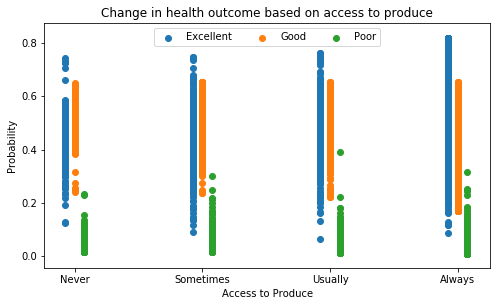

In [10]:
exc, good, poor = zip(*model_ordinal.predict_proba(x))

plt.figure(figsize=(8,4.5))
plt.scatter(data['acc_produce']-0.075, np.array(exc), label = 'Excellent')
plt.scatter(data['acc_produce'], np.array(good), label = 'Good')
plt.scatter(data['acc_produce']+0.075, np.array(poor), label ='Poor')

plt.legend(loc='upper center', ncol=3)

positions = (1, 2, 3, 4)
labels = ('Never', 'Sometimes', 'Usually', 'Always')
plt.xticks(positions, labels)

plt.xlabel ('Access to Produce')
plt.ylabel ('Probability')
plt.title ('Change in health outcome based on access to produce');

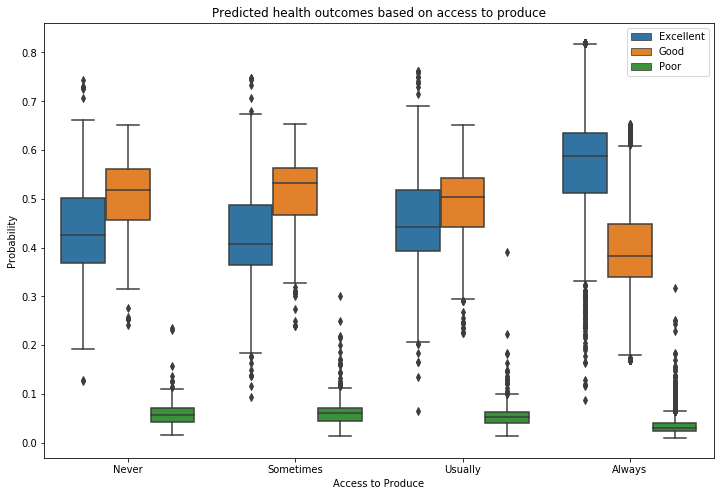

In [38]:
melted_df=pd.melt(df_predict, id_vars = ['acc_produce'], value_vars = ['pred_exc', 'pred_good', 'pred_poor'])

plt.figure(figsize=(12,8))

ax = sns.boxplot('acc_produce', 'value', data = melted_df,
            hue = 'variable')

plt.xlabel('Access to Produce'),
plt.ylabel('Probability'),
plt.title('Predicted health outcomes based on access to produce')

positions = (0, 1, 2, 3)
labels = ('Never', 'Sometimes', 'Usually', 'Always')
plt.xticks(positions, labels)


handles, _ = ax.get_legend_handles_labels()
legend = ['Excellent', 'Good', 'Poor']
plt.legend(handles, legend);